## Algoritmo LSTM

In [148]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import timedelta
from tensorflow.keras.callbacks import EarlyStopping
import random
import joblib

In [158]:
# Establecer una semilla aleatoria
seed_value = 36
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(48)

In [159]:
nombre_csv = 4003
de = pd.read_csv(f'Datos_entrenamiento2/{nombre_csv}_e.csv')
dp = pd.read_csv(f'Datos_prueba2/{nombre_csv}_p.csv')

# Procesamiento

In [160]:
# Separar características y etiquetas del conjunto de entrenamiento
X_train = de[['period eating','period other','period resting','period rumination']]
y_train = de[['nivel_actividad']]
# Separar características y etiquetas del conjunto de prueba
X_test = dp[['period eating','period other','period resting','period rumination']]
y_test = dp[['nivel_actividad']]

In [161]:
# Estandarizar las características
# scaler = StandardScaler() 
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # guardar estandarización
# joblib.dump(scaler, f'scalers/{nombre_csv}_scaler.pkl')


In [162]:
#Expandir a 24 horas de datos para capturar ciclo diario
timesteps = 24
# X_train_reshaped = np.array([X_train_scaled[i:i + timesteps] for i in range(len(X_train_scaled) - timesteps)])
# y_train = y_train[timesteps:]
# X_test_reshaped = np.array([X_test_scaled[i:i + timesteps] for i in range(len(X_test_scaled) - timesteps)])
# y_test = y_test[timesteps:]
X_train_reshaped = np.array([X_train[i:i + timesteps] for i in range(len(X_train) - timesteps)])
y_train = y_train[timesteps:]
X_test_reshaped = np.array([X_test[i:i + timesteps] for i in range(len(X_test) - timesteps)])
y_test = y_test[timesteps:]

# ALGORITMO DE LSTM

In [163]:
# Construir el modelo LSTM
model = Sequential([
        LSTM(36, activation='relu', input_shape=(timesteps, X_train.shape[1]), 
             return_sequences=True),
        LSTM(96, activation='relu'),
        Dense(48, activation='relu'),
        Dense(6),
        Dense(1)  # Cambio a regresión lineal sin activación
    ])

    
    # Usar mean_squared_error para regresión
model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error',metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
history = model.fit(
        X_train_reshaped, y_train,
        epochs=50,
        batch_size=36,
        validation_data=(X_test_reshaped, y_test),
        callbacks=[early_stopping],
        verbose=1
)

Epoch 1/50


C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0498 - mae: 0.1912 - val_loss: 0.0526 - val_mae: 0.1856
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0465 - mae: 0.1826 - val_loss: 0.0464 - val_mae: 0.1771
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0436 - mae: 0.1754 - val_loss: 0.0389 - val_mae: 0.1603
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0403 - mae: 0.1662 - val_loss: 0.0362 - val_mae: 0.1533
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0389 - mae: 0.1624 - val_loss: 0.0334 - val_mae: 0.1469
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0380 - mae: 0.1593 - val_loss: 0.0330 - val_mae: 0.1451
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0375 - mae: 0.1577 - val_loss: 0.0326 - val_mae: 0.1440
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0373 - mae: 0.1570 - val_loss: 0.0336 - val_mae: 0.1462
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0370 - mae: 0.

In [164]:
# Guardar el modelo completo
model.save(f'entrenamientos/{nombre_csv}_modelo_actividad.h5')


In [165]:
#  Predecir en los Datos de Prueba
y_pred = model.predict(X_test_reshaped)

# Gráfica de Resultados
horas = pd.to_datetime(dp['Fecha'] + ' ' + dp['Hora'].astype(str) + ':00:00')[timesteps:].reset_index(drop=True)  # Horas de prueba ajustadas
real_stress = y_test.reset_index(drop=True)
pred_stress = y_pred

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


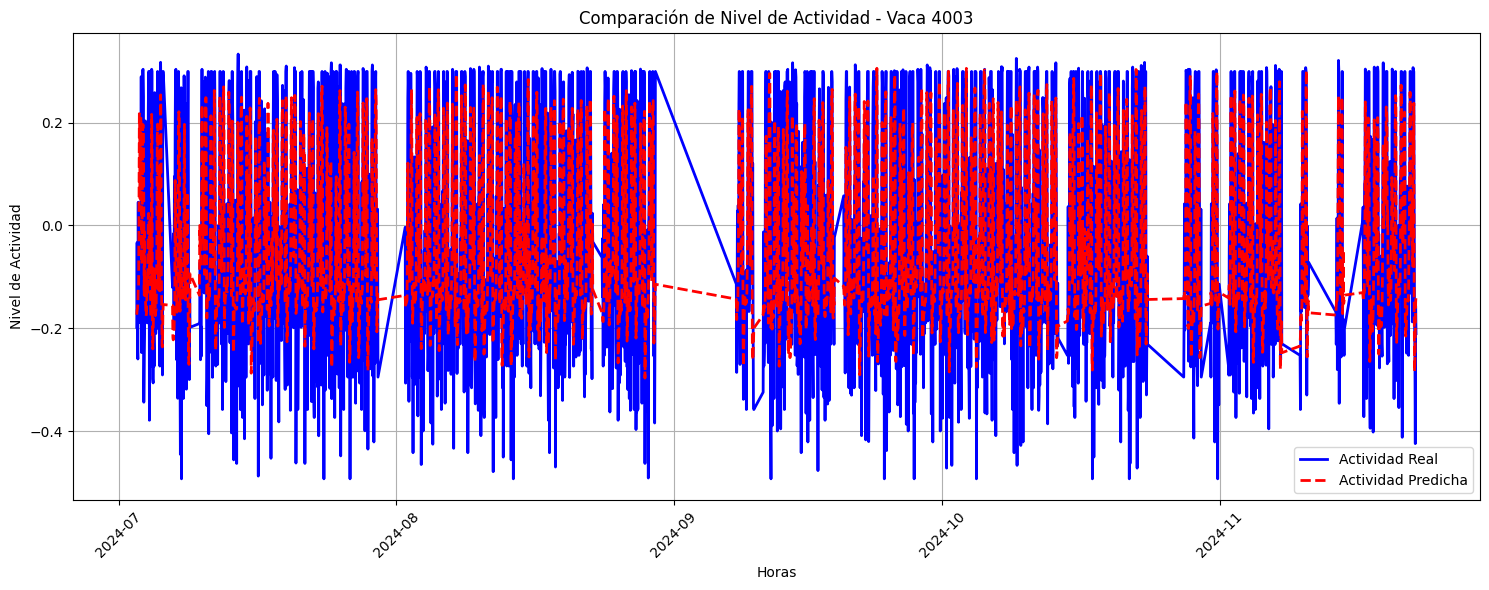

In [166]:
plt.figure(figsize=(15, 6))
    
plt.plot(horas, real_stress, label='Actividad Real', color='blue', linewidth=2)
plt.plot(horas, pred_stress, label='Actividad Predicha', color='red', 
        linestyle='--', linewidth=2)

plt.title(f'Comparación de Nivel de Actividad - Vaca {nombre_csv}')
plt.xlabel('Horas')
plt.ylabel('Nivel de Actividad')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()